# Correlations between transcriptome and OTU microbiome data

Notebook to run correlations between the host transcriptome data and OTUs from Dr. Wallace [manuscript](https://apsjournals.apsnet.org/doi/full/10.1094/PBIOMES-02-18-0008-R).

## Datasets

### RNAseq data

Matrix with TPM values from quantifying (Salmon) with cleaned reads against the maize transcriptome (representative transcripts of maize version 5)

### 16S data

The matrix that will be used corresponds to the OTU table generated by Dr. Wallace, which is in the FigShare repository lited in [Wallace et al. (2018)](https://apsjournals.apsnet.org/doi/full/10.1094/PBIOMES-02-18-0008-R).

## Association of identifiers between RNAseq (Kremling et al. 2018) and 16S datasets (Wallace et al. 2018)

File `0_kremling_expression_key.txt` from the publication FigShare has association of identifiers between samples.
The NCBI SRA records have associations between the unique identifiers in each dataset (RNAseq or 16S) and the associations with the SRA unique identifiers.

In [1]:
#kremling_expression_key = '/media/renato/SSD1TB/Repositories/maize_microbiome_transcriptomics/correlations_rnaseq_metataxonomics/0_kremling_expression_key.txt'
#sra_run_table_16s = '/media/renato/SSD1TB/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/SraRunInfo_Wallace_etal_2018.csv'
#sra_run_table_rnaseq = '/media/renato/SSD1TB/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/run_info/SraRunInfo_Kremling_etal_2018.csv'
kremling_expression_key = '/home/rsantos/Repositories/maize_microbiome_transcriptomics/correlations_rnaseq_metataxonomics/0_kremling_expression_key.txt'
sra_run_table_16s = '/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/SraRunInfo_Wallace_etal_2018.csv'
sra_run_table_rnaseq = '/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/run_info/SraRunInfo_Kremling_etal_2018.csv'

dict_wallace_kremling_2018 = {}
kremling_expression_key_dict = {}

In [2]:
with open(kremling_expression_key, 'r') as file:

    _ = file.readline()

    for line in file:
        fields = line.strip().split('\t')
        
        kremling_identifier = fields[0]
        wallace_identifier = fields[1]

        # Adding both identifiers (Wallace and Kremling) to the dictionary
        kremling_expression_key_dict[kremling_identifier] = wallace_identifier
        kremling_expression_key_dict[wallace_identifier] = kremling_identifier

In [3]:
import re

with open(sra_run_table_rnaseq, 'r') as file:

    _ = file.readline()

    for line in file:
        fields = line.strip().split(',')
        fields2 = fields[11].split('_')
        rnaseq_run_id = fields[0]
        sample_id = fields2[1]
        rnaseq_genotype = fields2[2]
        day = ''
        match = re.search(r'\d+', sample_id)
        unmatched_parts = re.split(r'\d+', sample_id)
        day_period = unmatched_parts[0]
        if match:
            day = int(match.group())
        if sample_id.startswith('LMA') and rnaseq_genotype != '#N/A':
            dict_wallace_kremling_2018[fields[11]] = {'run_accession_16s': '',
                                    'run_accession_rnaseq': rnaseq_run_id,
                                    'day': day,
                                    'day_period': day_period,
                                    'genotype_16s': '',
                                    'genotype_rnaseq': rnaseq_genotype}

In [4]:
rnaseq_samples_with_16s = 0

with open(sra_run_table_16s, 'r') as file:

    _ = file.readline()

    for line in file:
        fields = line.strip().split(',')
        fields2 = fields[11].split('.')
        metataxonomics_run_id = fields[0]
        day = int(fields2[1])
        day_period = fields2[0]
        for key, value in kremling_expression_key_dict.items():
            if value == fields[11]:
                if dict_wallace_kremling_2018[key]['day'] != day:
                    print('Big problem!')
                    print(day, dict_wallace_kremling_2018[key]['day'])
                    print(dict_wallace_kremling_2018[key])
                    print(value, fields[11], key)
                    exit(1)
                if dict_wallace_kremling_2018[key]['day_period'] != day_period:
                    if key == '10343927_LMAN8_CML505_CAACAG':
                        continue
                    else:
                        print(day_period, dict_wallace_kremling_2018[key]['day_period'])
                        print(dict_wallace_kremling_2018[key])
                        print(value, fields[11], key)
                        exit(1)
                dict_wallace_kremling_2018[key]['run_accession_16s'] = metataxonomics_run_id
                rnaseq_samples_with_16s+=1

print(f'{rnaseq_samples_with_16s} sample pairs found.')

484 sample pairs found.


In [5]:
no_16s = 0
for key, value in dict_wallace_kremling_2018.items():
    if value['run_accession_16s'] == '':
        print(key, value)
        no_16s+=1
print(f'{no_16s} samples without 16S data.')

10343927_LMAN8_B73_CACACT {'run_accession_16s': '', 'run_accession_rnaseq': 'SRR5909633', 'day': 8, 'day_period': 'LMAN', 'genotype_16s': '', 'genotype_rnaseq': 'B73'}
10343927_LMAN8_CML505_CAACAG {'run_accession_16s': '', 'run_accession_rnaseq': 'SRR5911345', 'day': 8, 'day_period': 'LMAN', 'genotype_16s': '', 'genotype_rnaseq': 'CML505'}
2 samples without 16S data.


# Generating a matrix with both RNAseq and OTUs from Wallace et al (2018)

Associations between 16S and RNAseq data are present in the 'dict_wallace_kremling_2018' dictionary.

In [6]:
run2my_sample_id = {}

for key in dict_wallace_kremling_2018:
    if dict_wallace_kremling_2018[key]['run_accession_rnaseq']:
        run2my_sample_id[dict_wallace_kremling_2018[key]['run_accession_rnaseq']] = key
    if dict_wallace_kremling_2018[key]['run_accession_16s']:
        run2my_sample_id[dict_wallace_kremling_2018[key]['run_accession_16s']] = key

In [7]:
import pandas as pd

# Importing expression data from Kremling et al. 2018 (TPM matrix on Maize v5 using Salmon after cleaning with TrimGalore)
#kremling_expression_v5 = pd.read_csv('/media/renato/SSD1TB/Projects/UGA_RACS/RNAseq/Salmon/Zma2_tpm_matrix.txt', sep='\t')
kremling_expression_v5 = pd.read_csv('/media/rsantos/4TB_drive/Projects/UGA_RACS/RNAseq/Salmon/Zma2_tpm_matrix.txt', sep='\t')

# Rename column and reset the index
kremling_expression_v5.set_index('Name', inplace=True)

# Print the dataframe
kremling_expression_v5.head()

,SRR5909626,SRR5909627,SRR5909633,SRR5909635,SRR5909639,SRR5909642,SRR5909645,SRR5909653,SRR5909655,SRR5909665,...,SRR5912073,SRR5912081,SRR5912082,SRR5912083,SRR5912093,SRR5912094,SRR5912104,SRR5912105,SRR5912111,SRR5912116
Name,,,,,,,,,,,,,,,,,,,,,
Zm00001eb371370_T002,1.04145,0.0000,3.391060,0.0,0.0000,1.82712,0.284514,2.23201,0.437147,0.468934,...,0.00000,1.51042,0.00000,0.0,0.00000,2.82055,3.96967,0.00000,2.96105,0.00000
Zm00001eb371350_T001,0.00000,0.0000,0.000000,0.0,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Zm00001eb371330_T001,0.00000,0.0000,0.000000,0.0,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Zm00001eb371310_T001,0.00000,0.0000,0.000000,0.0,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Zm00001eb371280_T001,1.27650,2.1092,0.692731,0.0,4.2798,1.47496,2.557320,0.00000,1.065940,1.149530,...,3.02253,0.41140,1.17447,0.0,3.48749,9.47506,6.19189,3.80776,1.03695,1.14981


#### Renaming columns

Renaming columns of Kremling data based on associations in 'run2my_sample_id':

In [8]:
kremling_expression_v5 = kremling_expression_v5.rename(columns=run2my_sample_id)
kremling_expression_v5.columns = [str(x) for x in kremling_expression_v5.columns]

kremling_expression_v5.head()

,10343927_LMAD26_CI21E_AAGTGG,10343264_LMAN26_CI21E_ATGAAC,10343927_LMAN8_B73_CACACT,10343264_LMAN26_B64_ACCAGT,10343262_LMAN8_B109_TGCTAT,10343262_LMAN8_B14A_CTCTCG,10343262_LMAN8_B57_CCTAAG,10343927_LMAD26_B77_TAATCG,10343262_LMAN8_B79_GCAGCC,10343927_LMAN8_CI187-2_GACGAT,...,10344826_LMAN8_I29_ACGTCT,10344823_LMAD8_IA2132_ACACGC,10343264_LMAD26_CML91_AACGCC,10344827_LMAN26_CML91_AATCCG,10344827_LMAN26_Ki21_AAGACA,10343927_LMAD26_Ki21_ACGTCT,10344826_LMAD8_E2558W_CGCAAC,10343927_LMAN8_E2558W_GAACCT,10344826_LMAD8_IDS69_CAGGAC,10343927_LMAN8_IDS69_ACATTA
Name,,,,,,,,,,,,,,,,,,,,,
Zm00001eb371370_T002,1.04145,0.0000,3.391060,0.0,0.0000,1.82712,0.284514,2.23201,0.437147,0.468934,...,0.00000,1.51042,0.00000,0.0,0.00000,2.82055,3.96967,0.00000,2.96105,0.00000
Zm00001eb371350_T001,0.00000,0.0000,0.000000,0.0,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Zm00001eb371330_T001,0.00000,0.0000,0.000000,0.0,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Zm00001eb371310_T001,0.00000,0.0000,0.000000,0.0,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Zm00001eb371280_T001,1.27650,2.1092,0.692731,0.0,4.2798,1.47496,2.557320,0.00000,1.065940,1.149530,...,3.02253,0.41140,1.17447,0.0,3.48749,9.47506,6.19189,3.80776,1.03695,1.14981


#### Testing correlations between D and N samples for RNAseq

Running correlations between all pairs of RNAseq samples - N and D - and generate a histogram of the values.

In [9]:
import numpy as np

rnaseq_pairs_cors = []
rnaseq_pairs2correlate = {}
ones = 0
twos = 0
threes_or_more = 0

for key in dict_wallace_kremling_2018.keys():
    if str(dict_wallace_kremling_2018[key]['day'])+'_'+dict_wallace_kremling_2018[key]['genotype_rnaseq'] not in rnaseq_pairs2correlate.keys():
        rnaseq_pairs2correlate[str(dict_wallace_kremling_2018[key]['day'])+'_'+dict_wallace_kremling_2018[key]['genotype_rnaseq']]=[key]
    else:
        rnaseq_pairs2correlate[str(dict_wallace_kremling_2018[key]['day'])+'_'+dict_wallace_kremling_2018[key]['genotype_rnaseq']].append(key)

for key in rnaseq_pairs2correlate.keys():
    if len(rnaseq_pairs2correlate[key]) == 1:
        ones+=1
    elif len(rnaseq_pairs2correlate[key]) == 2:
        twos+=1
        column1 = kremling_expression_v5[rnaseq_pairs2correlate[key][0]]
        column2 = kremling_expression_v5[rnaseq_pairs2correlate[key][1]]
        correlation = np.corrcoef(column1, column2)[0, 1]
        rnaseq_pairs_cors.append(correlation)
    elif len(rnaseq_pairs2correlate[key]) >= 3:
        threes_or_more+=1
    else:
        continue

print(f'cases with ones: {ones}')
print(f'cases with twos: {twos}')
print(f'cases with threes: {threes_or_more}')

cases with ones: 60
cases with twos: 203
cases with threes: 2


There are 203 pairs (day and night) of samples in the RNAseq data available for the correlation analyses. I (RACS) used these pairs to see an overall distribution of the correlation values (how day and night samples correlate with each other).

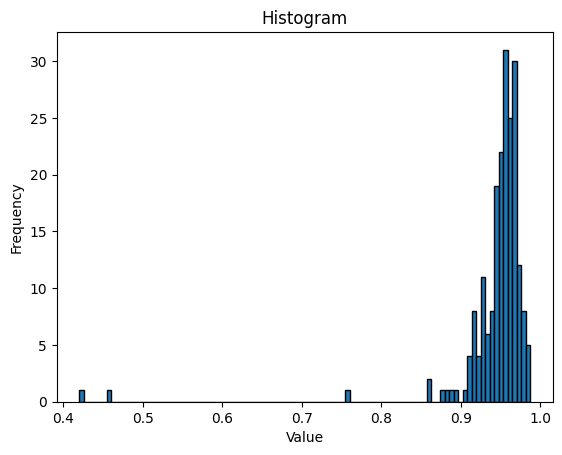

In [10]:
import matplotlib.pyplot as plt

# Build histogram
plt.hist(rnaseq_pairs_cors, bins=100, edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')

# Show the plot
plt.show()

It looks like there is a high correlation in most of the pairs (D and N for same genes).

However, we (RACS and JW) decided to run correlations between OTUs and RNAseq for days and night, independently, to see which correlations are common and specific to each day period.

#### Importing OTU data

OTU table was obtained from the FigShare repo associated with Wallace et al. (2018), with the `.biom` extension.
It was converted to a tabular file as described in the Gitlab wiki associated with this project (first line of hashtag was removed and 'OTU ID' column was renamed to 'OTU'). Since the taxonomy is not important at this initial moment, the taxonomy column was also removed from the table. Next, day and nigth samples were merged for the OTU table.

#### Importing OTU data with merged day and night samples

OTU counts for day and night samples were merged in a separate notebook and imported:

In [11]:
#otu_table_merged_d_n = pd.read_csv('/media/renato/SSD1TB/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/summed_day_night_otu_counts.tsv',
#                                   sep='\t', index_col='OTU ID')
otu_table_merged_d_n = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/summed_day_night_otu_counts.tsv',
                                   sep='\t', index_col='OTU ID')
                                   
otu_table_merged_d_n.head()

,14A0247_8,14A0051_8,14A0381_26,14A0533_26,14A0281_8,14A0295_8,14A0169_26,14A0069_8,14A0497_26,14A0023_8,...,14A0345_8,14A0267_8,14A0009_8,14A0007_8,14A0093_26,14A0137_26,14A0265_8,14A0155_26,14A0167_26,14A0481_26
OTU ID,,,,,,,,,,,,,,,,,,,,,
4479944,1.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
995900,0.0,0.0,0.0,0.0,5.0,8.0,6.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1124709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
541139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
533625,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,40.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0


Creating a dictionary that will be used later to rename columns of the RNAseq matrix (to match 16S columns):

In [12]:
kremling2merged_d_n = {}

for key, value in rnaseq_pairs2correlate.items():
    if len(rnaseq_pairs2correlate[key]) == 2:
        for rnaseq_id in rnaseq_pairs2correlate[key]:
            fields = kremling_expression_key_dict[rnaseq_id].split('.')
            kremling2merged_d_n[rnaseq_id] = fields[2]+'_'+str(fields[1])

#### Selecting Day and Night samples separately for the RNAseq

For creating the dataframes with day and night RNAseq samples, I (RACS):

 * Ensured to select samples that had pairs (day and night samples were available)
 * Ensured there was a corresponding set of microbiome samples for the same set of RNAseq

In [13]:
kremling2_day_samples_dict = {}
kremling2_night_samples_dict = {}
problematic_samples = []

for key, value in rnaseq_pairs2correlate.items():
    if len(rnaseq_pairs2correlate[key]) == 2:
        n_count = 0
        d_count = 0
        for plot_day_id in rnaseq_pairs2correlate[key]:
            fields = kremling_expression_key_dict[plot_day_id].split('.')
            if fields[0] == 'LMAD' and d_count == 0:
                kremling2_day_samples_dict[plot_day_id] = fields[2]+'_'+str(fields[1])
                d_count+=1
            elif fields[0] == 'LMAN' and n_count == 0:
                kremling2_night_samples_dict[plot_day_id] = fields[2]+'_'+str(fields[1])
                n_count+=1
            else:
                problematic_samples.append(rnaseq_pairs2correlate[key])

print(f'There are {len(kremling2_day_samples_dict)} day samples')
print(f'There are {len(kremling2_night_samples_dict)} night samples')

There are 203 day samples
There are 202 night samples


In [14]:
kremling_expression_v5_day = kremling_expression_v5.filter(items=list(kremling2_day_samples_dict.keys()))
print(kremling_expression_v5_day.shape)
print(kremling_expression_v5_day.head(n=2))
kremling_expression_v5_night = kremling_expression_v5.filter(items=list(kremling2_night_samples_dict.keys()))
print(kremling_expression_v5_night.shape)
print(kremling_expression_v5_night.head(n=2))

(39096, 203)
                      10343927_LMAD26_CI21E_AAGTGG  \
Name                                                 
Zm00001eb371370_T002                       1.04145   
Zm00001eb371350_T001                       0.00000   

                      10343927_LMAD26_B64_GCGAAT  10343927_LMAD26_B77_TAATCG  \
Name                                                                           
Zm00001eb371370_T002                    0.450365                     2.23201   
Zm00001eb371350_T001                    0.000000                     0.00000   

                      10344823_LMAD8_A661_GTCAGG  10344823_LMAD8_A679_TAGGCT  \
Name                                                                           
Zm00001eb371370_T002                     3.43127                     2.25646   
Zm00001eb371350_T001                     0.00000                     0.00000   

                      10343927_LMAD26_4226_TGGCGA  \
Name                                                
Zm00001eb371370_T002  

In [15]:
kremling_expression_v5_day_renamed = kremling_expression_v5_day.rename(columns=kremling2merged_d_n)
print(kremling_expression_v5_day_renamed.head())
kremling_expression_v5_night_renamed = kremling_expression_v5_night.rename(columns=kremling2merged_d_n)
print(kremling_expression_v5_night_renamed.head())

                      14A0253_26  14A0041_26  14A0171_26  14A0045_8  \
Name                                                                  
Zm00001eb371370_T002     1.04145    0.450365     2.23201    3.43127   
Zm00001eb371350_T001     0.00000    0.000000     0.00000    0.00000   
Zm00001eb371330_T001     0.00000    0.000000     0.00000    0.00000   
Zm00001eb371310_T001     0.00000    0.000000     0.00000    0.00000   
Zm00001eb371280_T001     1.27650    0.736011     0.00000    2.40324   

                      14A0085_8  14A0079_26  14A0467_26  14A0039_8  14A0095_8  \
Name                                                                            
Zm00001eb371370_T002    2.25646    0.529255     2.98970    2.93577    3.08344   
Zm00001eb371350_T001    0.00000    0.000000     0.00000    0.00000    0.00000   
Zm00001eb371330_T001    0.00000    0.000000     0.00000    0.00000    0.00000   
Zm00001eb371310_T001    0.00000    0.000000     0.00000    0.00000    0.00000   
Zm00001eb371280_

In [16]:
otu_table_merged_day = otu_table_merged_d_n.filter(items=list(kremling2_day_samples_dict.values()))
print(otu_table_merged_day.shape)
otu_table_merged_night = otu_table_merged_d_n.filter(items=list(kremling2_night_samples_dict.values()))
print(otu_table_merged_night.shape)

(9057, 173)
(9057, 172)


In [17]:
kremling_expression_v5_day_renamed_filtered = kremling_expression_v5_day_renamed.filter(items=otu_table_merged_day.columns)
print(kremling_expression_v5_day_renamed_filtered.shape)
kremling_expression_v5_night_renamed_filtered = kremling_expression_v5_night_renamed.filter(items=otu_table_merged_night.columns)
print(kremling_expression_v5_night_renamed_filtered.shape)

(39096, 173)
(39096, 172)


In [18]:
if kremling_expression_v5_day_renamed_filtered.columns.all() == otu_table_merged_day.columns.all():
    print('Columns are equal (day)!')
if kremling_expression_v5_night_renamed_filtered.columns.all() == otu_table_merged_night.columns.all():
    print('Columns are equal (night)!')

Columns are equal (day)!
Columns are equal (night)!


In [19]:
def count_zeros(df, threshold=0.5):
    # Count the number of zeros in each row
    # If the number of zeros is greater than the threshold, remove the row
    threshold_int = int(df.shape[1] * threshold)
    print(f'Threshold: {threshold_int} (threshold * number of columns)')
    zero_counts = df.apply(lambda row: (row == 0).sum(), axis=1)
    return df[zero_counts < threshold_int]

In [27]:
import pandas as pd

otu_table_merged_day_cpm = otu_table_merged_day.divide(otu_table_merged_day.sum())
otu_table_merged_day_cpm = otu_table_merged_day_cpm * 1e6
otu_table_merged_night_cpm = otu_table_merged_night.divide(otu_table_merged_night.sum())
otu_table_merged_night_cpm = otu_table_merged_night_cpm * 1e6

In [65]:
otu_table_merged_day_zeros_filtered = count_zeros(otu_table_merged_day_cpm)
otu_table_merged_night_zeros_filtered = count_zeros(otu_table_merged_night_cpm)
kremling_expression_v5_day_renamed_zeros_filtered = count_zeros(kremling_expression_v5_day_renamed_filtered)
kremling_expression_v5_night_renamed_zeros_filtered = count_zeros(kremling_expression_v5_night_renamed_filtered)
print(otu_table_merged_day_zeros_filtered.shape)
print(otu_table_merged_night_zeros_filtered.shape)
print(kremling_expression_v5_day_renamed_zeros_filtered.shape)
print(kremling_expression_v5_night_renamed_zeros_filtered.shape)

Threshold: 86 (threshold * number of columns)
Threshold: 86 (threshold * number of columns)
Threshold: 86 (threshold * number of columns)
Threshold: 86 (threshold * number of columns)
(1117, 173)
(1135, 172)
(19692, 173)
(20049, 172)


In [66]:
# Calculate the coefficient of variation for each row
otu_table_merged_day_zeros_filtered_cv = otu_table_merged_day_zeros_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
otu_table_merged_night_zeros_filtered_cv = otu_table_merged_night_zeros_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)

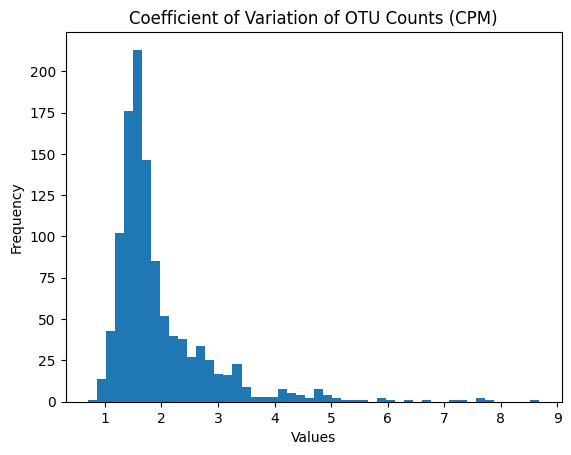

In [67]:
import matplotlib.pyplot as plt

otu_table_merged_day_zeros_filtered_cv.plot.hist(bins=50)

# Set the title and labels
plt.title("Coefficient of Variation of OTU Counts (CPM)")
plt.xlabel("Values")
plt.ylabel("Frequency")

# Show the plot
plt.show()

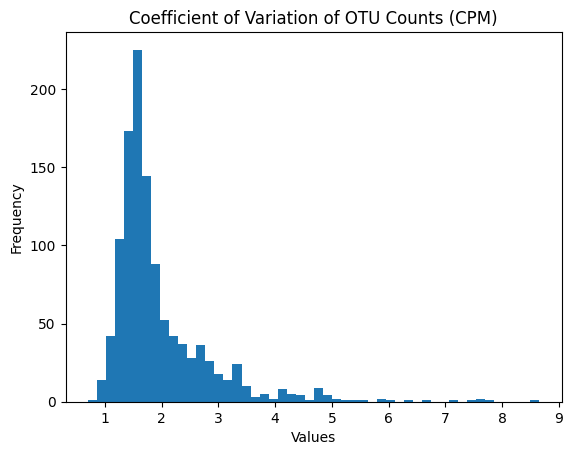

In [68]:
import matplotlib.pyplot as plt

otu_table_merged_night_zeros_filtered_cv.plot.hist(bins=50)

# Set the title and labels
plt.title("Coefficient of Variation of OTU Counts (CPM)")
plt.xlabel("Values")
plt.ylabel("Frequency")

# Show the plot
plt.show()

In [72]:
# Calculate the coefficient of variation for each row
otu_table_merged_day_zeros_filtered_cv2 = otu_table_merged_day_zeros_filtered.loc[otu_table_merged_day_zeros_filtered_cv[otu_table_merged_day_zeros_filtered_cv > 2].index]
otu_table_merged_night_zeros_filtered_cv2 = otu_table_merged_night_zeros_filtered.loc[otu_table_merged_night_zeros_filtered_cv[otu_table_merged_night_zeros_filtered_cv > 2].index]
print(otu_table_merged_day_zeros_filtered_cv2.shape)
print(otu_table_merged_night_zeros_filtered_cv2.shape)


(334, 173)
(340, 172)


In [57]:
# Calculate the coefficient of variation for each row
kremling_expression_v5_day_renamed_zeros_filtered_cv = kremling_expression_v5_day_renamed_zeros_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
kremling_expression_v5_night_renamed_zeros_filtered_cv = kremling_expression_v5_night_renamed_zeros_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)

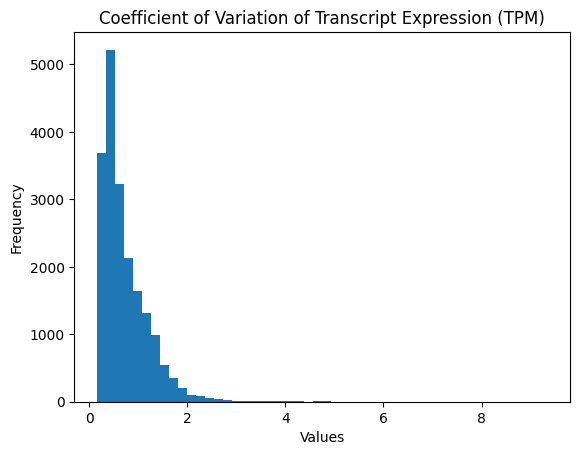

In [58]:
import matplotlib.pyplot as plt

kremling_expression_v5_day_renamed_zeros_filtered_cv.plot.hist(bins=50)

# Set the title and labels
plt.title("Coefficient of Variation of Transcript Expression (TPM)")
plt.xlabel("Values")
plt.ylabel("Frequency")

# Show the plot
plt.show()

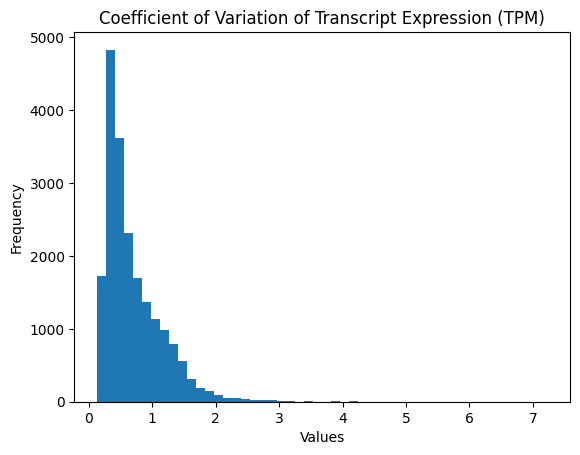

In [60]:
import matplotlib.pyplot as plt

kremling_expression_v5_night_renamed_zeros_filtered_cv.plot.hist(bins=50)

# Set the title and labels
plt.title("Coefficient of Variation of Transcript Expression (TPM)")
plt.xlabel("Values")
plt.ylabel("Frequency")

# Show the plot
plt.show()

In [73]:
kremling_expression_v5_day_renamed_zeros_filtered_cv1 = kremling_expression_v5_day_renamed_zeros_filtered.loc[kremling_expression_v5_day_renamed_zeros_filtered_cv[kremling_expression_v5_day_renamed_zeros_filtered_cv > 1].index]
kremling_expression_v5_night_renamed_zeros_filtered_cv1 = kremling_expression_v5_night_renamed_zeros_filtered.loc[kremling_expression_v5_night_renamed_zeros_filtered_cv[kremling_expression_v5_night_renamed_zeros_filtered_cv > 1].index]
print(kremling_expression_v5_day_renamed_zeros_filtered_cv1.shape)
print(kremling_expression_v5_night_renamed_zeros_filtered_cv1.shape)

(4426, 173)
(4330, 172)


In [74]:
concatenated_day_df = pd.concat([kremling_expression_v5_day_renamed_zeros_filtered_cv1,
                             otu_table_merged_day_zeros_filtered_cv2], axis=0)
concatenated_night_df = pd.concat([kremling_expression_v5_night_renamed_zeros_filtered_cv1,
                             otu_table_merged_night_zeros_filtered_cv2], axis=0)

concatenated_day_transposed = concatenated_day_df.T
concatenated_night_transposed = concatenated_night_df.T
print(concatenated_day_transposed.shape)
print(concatenated_night_transposed.shape)

(173, 4760)
(172, 4670)


In [76]:
from corals.threads import set_threads_for_external_libraries
set_threads_for_external_libraries(n_threads=1)
import numpy as np
from corals.correlation.full.default import cor_full

cor_d_values = cor_full(concatenated_day_transposed)
cor_d_values.shape

highly_correlated_pairs_d_df = pd.DataFrame(columns=['feature1', 'feature2', 'correlation'])
correlated_pairs_file = open('correlated_pairs_merged_otus_day_transcripts.txt', 'w')

# Find the highly correlated pairs
for i in range(len(cor_d_values.columns)):
    for j in range(i+1, len(cor_d_values.columns)):
        if cor_d_values.columns[i] == cor_d_values.columns[j] or\
            (str(cor_d_values.columns[j]).startswith('Zm') and str(cor_d_values.columns[i]).startswith('Zm')):
            continue
        if ((abs(cor_d_values.iloc[i, j]) > 0.6) or\
           (abs(cor_d_values.iloc[i, j]) < -0.6)) and\
            (str(cor_d_values.columns[j]).startswith('Zm') or str(cor_d_values.columns[i]).startswith('Zm')):
            pair = (cor_d_values.columns[i], cor_d_values.columns[j])
            highly_correlated_pairs_d_df.loc[len(highly_correlated_pairs_d_df.index)] = [cor_d_values.columns[i],
                                                                                     cor_d_values.columns[j],
                                                                                     cor_d_values.iloc[i, j]]
            correlated_pairs_file.write(f'{cor_d_values.columns[i]}\t{cor_d_values.columns[j]}\t{cor_d_values.iloc[i, j]}\n')

correlated_pairs_file.close()

cor_n_values = cor_full(concatenated_night_transposed)
cor_n_values.shape

highly_correlated_pairs_n_df = pd.DataFrame(columns=['feature1', 'feature2', 'correlation'])
correlated_pairs_file = open('correlated_pairs_merged_otus_night_transcripts.txt', 'w')

# Find the highly correlated pairs
for i in range(len(cor_n_values.columns)):
    for j in range(i+1, len(cor_n_values.columns)):
        if cor_n_values.columns[i] == cor_n_values.columns[j] or\
            (str(cor_n_values.columns[j]).startswith('Zm') and str(cor_n_values.columns[i]).startswith('Zm')):
            continue
        if ((abs(cor_n_values.iloc[i, j]) > 0.6) or\
           (abs(cor_n_values.iloc[i, j]) < -0.6)) and\
            (str(cor_n_values.columns[j]).startswith('Zm') or str(cor_n_values.columns[i]).startswith('Zm')):
            pair = (cor_n_values.columns[i], cor_n_values.columns[j])
            highly_correlated_pairs_n_df.loc[len(highly_correlated_pairs_n_df.index)] = [cor_n_values.columns[i],
                                                                                     cor_n_values.columns[j],
                                                                                     cor_n_values.iloc[i, j]]
            correlated_pairs_file.write(f'{cor_n_values.columns[i]}\t{cor_n_values.columns[j]}\t{cor_n_values.iloc[i, j]}\n')

correlated_pairs_file.close()

/home/rsantos/Repositories/maize_microbiome_transcriptomics/.venv/lib/python3.10/site-packages/corals/threads.py:48: UserWarning: This function should be called before `numpy` or similar modules are imported.
  warnings.warn("This function should be called before `numpy` or similar modules are imported.")


In [77]:
import pandas as pd
import matplotlib.pyplot as plt

grouped = df.groupby([pd.cut(df['values'], ranges), 'class']).size().unstack()

# Plot the histogram for each class
grouped.plot(kind='bar', stacked=True)

# Set the labels and title
plt.xlabel('Value Ranges')
plt.ylabel('Count')
plt.title('Histogram of Values by Class')

# Show the plot
plt.show()


,feature1,feature2,correlation
0,Zm00001eb368660_T001,New.ReferenceOTU1486,0.613635
1,Zm00001eb366860_T002,New.ReferenceOTU3269,0.741192
2,Zm00001eb363720_T002,928829,0.679813
3,Zm00001eb363720_T002,822187,0.662187
4,Zm00001eb358290_T002,808437,0.636430
